In [14]:
import yfinance as yf
from datetime import date
import pandas as pd
import numpy as np
from sklearn import metrics
from math import sqrt
import matplotlib.pyplot as plt

In [15]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [16]:
# Input dari pengguna untuk simbol saham
symbol = input("Masukkan simbol saham (misalnya 'AAPL'): ")
start_date = date(2018, 1, 1)
end_date = date(2023, 9, 1)

# Mengunduh data saham dari Yahoo Finance
data = yf.download(symbol, start=start_date, end=end_date)

# Menambahkan kolom tanggal sebagai indeks
data.reset_index(inplace=True)

# Input dari pengguna untuk fitur yang akan digunakan
input_feat = input("Masukkan fitur yang akan digunakan (misalnya 'Close'): ")

# Memilih kolom tanggal dan fitur yang akan digunakan
data = data[["Date", input_feat]]

print(data)

c:\Users\kevin\miniconda3\envs\tf\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


           Date   Close
0    2018-01-01  3640.0
1    2018-01-02  3630.0
2    2018-01-03  3610.0
3    2018-01-04  3550.0
4    2018-01-05  3590.0
...         ...     ...
1404 2023-08-25  5600.0
1405 2023-08-28  5550.0
1406 2023-08-29  5600.0
1407 2023-08-30  5525.0
1408 2023-08-31  5550.0

[1409 rows x 2 columns]


In [17]:
# Melakukan penskalaan fitur
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[input_feat].values.reshape(-1, 1))

print(scaled_data)
print(dir(scaled_data))

[[0.41643059]
 [0.41359773]
 [0.40793201]
 ...
 [0.97167139]
 [0.95042493]
 [0.95750708]]
['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__class_getitem__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__divmod__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__mul__', '__ne__', '__neg__', '__new_

In [18]:
# Pembagian data menjadi data latih dan data uji
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size, :], scaled_data[train_size:, :]


print(train_data)
print(train_data.shape)
print(dir(train_data))

[[0.41643059]
 [0.41359773]
 [0.40793201]
 ...
 [0.52974504]
 [0.54390935]
 [0.54107649]]
(1127, 1)
['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__class_getitem__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__divmod__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__mul__', '__ne__', '__neg__

In [19]:
# Persiapan data untuk model LSTM
def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        target.append(data[i+sequence_length])
    return np.array(sequences), np.array(target)

sequence_length = 10  # Anda dapat mengubah panjangnya sesuai kebutuhan
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

vocab_size = 10000  # Contoh: Anda membatasi kosakata hingga 10.000 kata paling umum.
embedding_dim = 100  # Contoh: Gunakan embedding dengan dimensi 100.


In [20]:
# Membangun model LSTM
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 100)           1000000   
                                                                 
 lstm_2 (LSTM)               (None, 10, 128)           117248    
                                                                 
 dropout_2 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,166,721
Trainable params: 1,166,721
No

Epoch 1/100


c:\Users\kevin\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


INFO:tensorflow:Assets written to: ../model/model3\assets


INFO:tensorflow:Assets written to: ../model/model3\assets


18/18 - 12s - loss: 0.0713 - accuracy: 8.9526e-04 - val_loss: 0.1569 - val_accuracy: 0.0000e+00 - 12s/epoch - 655ms/step
Epoch 2/100


INFO:tensorflow:Assets written to: ../model/model3\assets


INFO:tensorflow:Assets written to: ../model/model3\assets


18/18 - 8s - loss: 0.0287 - accuracy: 8.9526e-04 - val_loss: 0.1216 - val_accuracy: 0.0000e+00 - 8s/epoch - 436ms/step
Epoch 3/100
18/18 - 0s - loss: 0.0275 - accuracy: 8.9526e-04 - val_loss: 0.1219 - val_accuracy: 0.0000e+00 - 347ms/epoch - 19ms/step
Epoch 4/100


INFO:tensorflow:Assets written to: ../model/model3\assets


INFO:tensorflow:Assets written to: ../model/model3\assets


18/18 - 7s - loss: 0.0279 - accuracy: 8.9526e-04 - val_loss: 0.1154 - val_accuracy: 0.0000e+00 - 7s/epoch - 407ms/step
Epoch 5/100


INFO:tensorflow:Assets written to: ../model/model3\assets


INFO:tensorflow:Assets written to: ../model/model3\assets


18/18 - 7s - loss: 0.0268 - accuracy: 8.9526e-04 - val_loss: 0.1065 - val_accuracy: 0.0000e+00 - 7s/epoch - 401ms/step
Epoch 6/100
18/18 - 0s - loss: 0.0269 - accuracy: 8.9526e-04 - val_loss: 0.1178 - val_accuracy: 0.0000e+00 - 455ms/epoch - 25ms/step
Epoch 7/100
18/18 - 0s - loss: 0.0267 - accuracy: 8.9526e-04 - val_loss: 0.1232 - val_accuracy: 0.0000e+00 - 257ms/epoch - 14ms/step
Epoch 8/100


INFO:tensorflow:Assets written to: ../model/model3\assets


INFO:tensorflow:Assets written to: ../model/model3\assets


18/18 - 7s - loss: 0.0281 - accuracy: 0.0000e+00 - val_loss: 0.0828 - val_accuracy: 0.0037 - 7s/epoch - 388ms/step
Epoch 9/100
18/18 - 0s - loss: 0.0277 - accuracy: 0.0000e+00 - val_loss: 0.1223 - val_accuracy: 0.0000e+00 - 393ms/epoch - 22ms/step
Epoch 10/100
18/18 - 0s - loss: 0.0268 - accuracy: 8.9526e-04 - val_loss: 0.0976 - val_accuracy: 0.0000e+00 - 251ms/epoch - 14ms/step
Epoch 11/100
18/18 - 0s - loss: 0.0272 - accuracy: 8.9526e-04 - val_loss: 0.0945 - val_accuracy: 0.0037 - 250ms/epoch - 14ms/step
Epoch 12/100
18/18 - 0s - loss: 0.0278 - accuracy: 8.9526e-04 - val_loss: 0.1373 - val_accuracy: 0.0000e+00 - 264ms/epoch - 15ms/step
Epoch 13/100
18/18 - 0s - loss: 0.0270 - accuracy: 8.9526e-04 - val_loss: 0.1227 - val_accuracy: 0.0000e+00 - 293ms/epoch - 16ms/step
Epoch 14/100
18/18 - 0s - loss: 0.0276 - accuracy: 8.9526e-04 - val_loss: 0.1014 - val_accuracy: 0.0000e+00 - 251ms/epoch - 14ms/step
Epoch 15/100
18/18 - 0s - loss: 0.0267 - accuracy: 8.9526e-04 - val_loss: 0.1176 - val

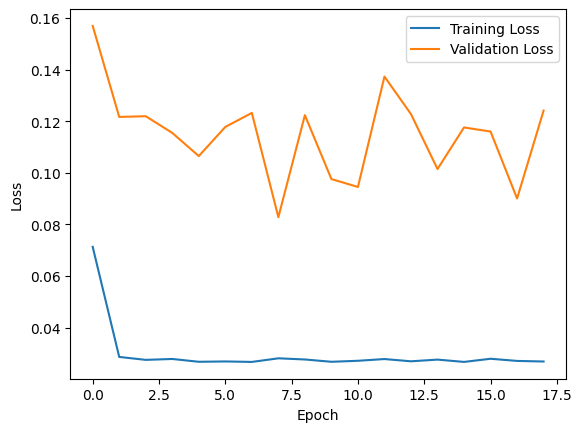

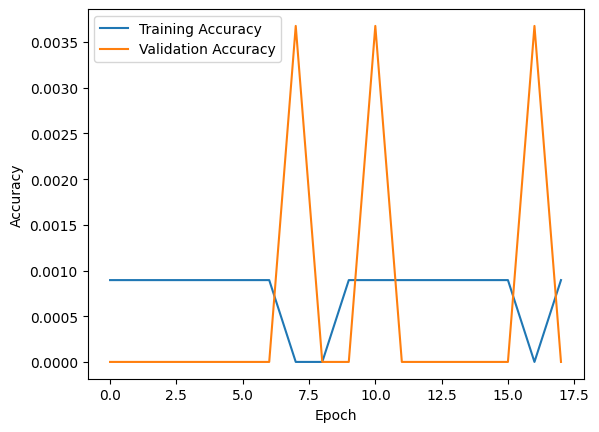

In [21]:
# Kompilasi dan pelatihan model
cp3 = ModelCheckpoint('../model/model3/', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


optimizer = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=2, callbacks=[cp3, early_stopping], validation_data=(X_test, y_test))

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot metrik lainnya (jika ada)
# Misalnya, jika Anda memiliki metrik akurasi:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
# Evaluasi model pada data uji
loss = model.evaluate(X_test, y_test)
print("Loss di data uji:", loss)

print("Loss di data uji:", loss)
predict = model.predict(X_test)
# print(predict)

9/9 [==============================] - 0s 7ms/step - loss: 0.0828 - accuracy: 0.0037
Loss di data uji: [0.0827992632985115, 0.0036764706019312143]
Loss di data uji: [0.0827992632985115, 0.0036764706019312143]
9/9 [==============================] - 1s 5ms/step


In [23]:
print("-"*50, " Metric ","-"*50)
print('RMSE : ',sqrt(metrics.mean_squared_error(y_test,predict)))
print('MSE  :  ',metrics.mean_squared_error(y_test,predict))
print('MAE  :  ',metrics.mean_absolute_error(y_test,predict))

print("-"*25, " Mengecek Apakah Nilainya Overfit atau tidak ","-"*25)
# print('-------------- Mengecek Apakah Nilainya Overfit atau tidak --------------')
print()


--------------------------------------------------  Metric  --------------------------------------------------
RMSE :  0.28774861863923823
MSE  :   0.08279926752878974
MAE  :   0.25139173472645004
-------------------------  Mengecek Apakah Nilainya Overfit atau tidak  -------------------------



In [24]:
# Simpan model
model.save("../model/lstm_model3.keras")